In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.conv_learner import *
from fastai.text import *

In [26]:
PATH = Path('data/IAM_handwriting')
TMP_PATH = PATH/'tmp'

!ls {PATH}

20_words.csv		     multi_synth_words.csv  synth_words.csv
ascii			     multi_synth_words.tgz  tmp
chars.csv		     paragraph_chars.csv    word_char_ids.csv
line_labels.csv		     paragraphs		    word_labels.csv
lines			     paragraphs.csv	    words
lines.tgz		     paragraphs_df.csv	    words_chars.csv
models			     paragraphs.tar.gz	    words.csv
multi_synth_words	     synth_words	    words.tgz
multi_synth_words_50000.csv  synth_words_50000.csv


In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# Synthesize Data

### images

In [5]:
synth_path = PATH/'testing_multi_synth_words'
os.makedirs(synth_path, exist_ok=True)

In [14]:
def create_img(files, fname, sz=None):
    if sz==None: sz=(1, len(files))  #(w,h)
    w = sz[0]
    h = sz[1]
        
    imgs    = [ PIL.Image.open(PATH/'words'/f) for f in files ]
    widths, heights = zip(*(i.size for i in imgs))
    
    max_height = max(heights)
    max_width  = max(widths)
    
    total_height = max_height * h #sum(heights)
    total_width  = max_width  * w

    new_im = Image.new('RGB', (total_width, total_height), color=(255,255,255))

    y_offset = 0
    x_offset = 0
    
    images = list(reversed(imgs))
    
    for row in range(h):
        x_offset = 0
        for col in range(w):
            i = images.pop()
            new_im.paste(i, (x_offset,y_offset))
            x_offset += (i.size[0]+50)
        y_offset += max_height

    new_im.save(synth_path/fname)

### pd.read_csv

In [105]:
df = pd.read_csv(f'{PATH}/ascii/words.txt', names=['filename','result','value'], escapechar='\\', delim_whitespace=True, skiprows=23, header=None, usecols=[0,1,8])
df.rename(columns={'value': 'word'}, inplace=True)

In [106]:
len(df)

75597

In [107]:
# remove errors
df = df[df.result != 'err']

In [108]:
# calculate character lengths
lgts = df.word.apply(len)  
df['char_len'] = lgts.astype('int32')

In [109]:
# lots of errors from pd.read_csv
# only keep rows w/ word length < 20
df = df[df.char_len < 20]

In [110]:
df = df.loc[df['char_len'] > 3]

In [111]:
df.head()

,filename,result,word,char_len
0,a01-000u-00-05,ok,Gaitskell,9
1,a01-000u-00-06,ok,from,4
2,a01-000u-01-00,ok,nominating,10
4,a01-000u-01-02,ok,more,4
5,a01-000u-01-03,ok,Labour,6


### manually created df

In [7]:
maxTextLen = 32
samples = []
chars = set()

f=open(f'{PATH}/ascii/words.txt')
for line in f:
    # ignore comment line
    if not line or line[0]=='#':
        continue

    lineSplit = line.strip().split(' ')
    assert len(lineSplit) >= 9

    fileName = lineSplit[0]

    # GT text are columns starting at 9
    gtText = ''.join(lineSplit[8:])[:maxTextLen]
    char_len = len(gtText)
    chars = chars.union(set(list(gtText)))

    # put sample into list
    samples.append([fileName, gtText, char_len])
    
data = np.stack(samples)
df = pd.DataFrame(data, columns=['filename', 'word', 'char_len'], )

In [8]:
df['char_len'] = df.char_len.astype('int32')
df = df.loc[df['char_len'] > 3]
df.head()

,filename,word,char_len
1,a01-000u-00-01,MOVE,4
3,a01-000u-00-03,stop,4
5,a01-000u-00-05,Gaitskell,9
6,a01-000u-00-06,from,4
7,a01-000u-01-00,nominating,10


### Create Data

In [13]:
# !rm -rf {synth_path}

# synth_path = PATH/'testing_multi_synth_words'
# os.makedirs(synth_path, exist_ok=True)

synth_path = PATH/'multi_synth_words'

In [15]:
def create_synth_data(num):
    d={}
    for i in range(num):
        res = df.sample(6)
        files = list(map(lambda x: x+'.png', res.filename.values))
        label = ' '.join(res.word.values)

        fname = '{:04d}'.format(i+10000)+'.png'
        create_img(files, fname, (2,3))
        d[fname] = label
    return d

d = create_synth_data(40000)
len(d)

40000

In [16]:
synth = pd.DataFrame({'filename': list(d.keys()), 'labels': list(d.values())})
synth.head()

,filename,labels
0,10000.png,very bargaining told Towards their services
1,10001.png,attending Francis motive been judge tell
2,10002.png,announced time thing have they sign
3,10003.png,Force there still bringing been home
4,10004.png,know long 15-year-olds which before wild


### Verify

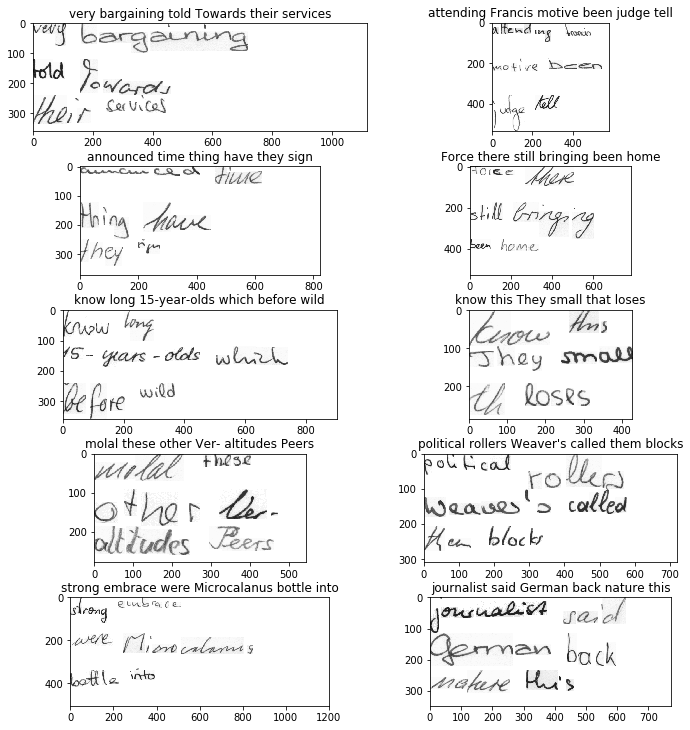

In [17]:
fig, axes = plt.subplots(5,2, figsize=(10, 10))
for i,ax in enumerate(axes.flat):
    row = synth.iloc[i]
    im = Image.open(synth_path/row.filename)
    ax.imshow(im)
    ax.set_title(row.labels)
    
plt.tight_layout(pad=0.2)

### Chars

In [113]:
chars = set()
for line in synth.labels:
    chars = chars.union(set(list(line)))
    
len(chars)

71

In [233]:
freq = Counter(char for word in synth.labels for char in word)
freq.most_common(25)

[(' ', 50000),
 ('e', 48515),
 ('t', 29202),
 ('a', 26088),
 ('i', 25911),
 ('r', 25646),
 ('n', 24615),
 ('s', 23796),
 ('o', 22734),
 ('l', 17346),
 ('h', 15649),
 ('d', 14129),
 ('c', 11933),
 ('u', 10707),
 ('m', 10263),
 ('g', 8734),
 ('p', 8360),
 ('y', 6601),
 ('w', 6464),
 ('f', 5658),
 ('b', 5269),
 ('v', 4722),
 ('k', 2566),
 ('-', 908),
 ('T', 906)]

### Numericalize characters

In [19]:
# same as used in single word / multi-word
itos = pickle.load(open(TMP_PATH/'char_itos.pkl', 'rb'))
len(itos)

82

In [234]:
# itos = [char for char,count in freq.most_common()]
# itos.insert(0, '_pad_')
# # leave index 1 as ' '
# itos.insert(2, '_eos_')
# itos.insert(3, '_unk_')
# len(itos)

74

In [20]:
joined_labels = list(synth.labels) #list(map(lambda x: ' '.join(x), labels))

stoi = collections.defaultdict(lambda: 3, {v:k for k,v in enumerate(itos)})
ids = np.array([np.array([stoi[letter] for letter in word] + [2]) for word in joined_labels])

In [21]:
# convert to strings (as labels)
str_ids = np.array([' '.join(str(l) for l in w) for w in ids]).reshape(-1,1)

In [22]:
synth['char_ids'] = str_ids
synth.head()

,filename,labels,char_ids
0,10000.png,very bargaining told Towards their services,77 60 73 80 1 57 56 73 62 56 64 69 64 69 62 1 ...
1,10001.png,attending Francis motive been judge tell,56 75 75 60 69 59 64 69 62 1 35 73 56 69 58 64...
2,10002.png,announced time thing have they sign,56 69 69 70 76 69 58 60 59 1 75 64 68 60 1 75 ...
3,10003.png,Force there still bringing been home,35 70 73 58 60 1 75 63 60 73 60 1 74 75 64 67 ...
4,10004.png,know long 15-year-olds which before wild,66 69 70 78 1 67 70 69 62 1 18 22 14 80 60 56 ...


In [240]:
# pickle.dump(itos, open(TMP_PATH/'multi_synth_itos.pkl', 'wb'))

### Append to DF

In [45]:
CSV = PATH/'multi_synth_words.csv'
csv = pd.read_csv(CSV)
len(csv)

10000

In [73]:
# CSV = PATH/'synth_words_50000.csv'
CSV = PATH/'multi_synth_words_50000.csv'

new = pd.concat([csv, synth[['filename', 'char_ids']]], ignore_index=True)
new.to_csv(CSV, columns=['filename', 'char_ids'], index=False)

In [74]:
len(new)

50000

### Modify csv/itos to match previous versions

In [63]:
itos_old = pickle.load(open(TMP_PATH/'synth_word_itos.pkl', 'rb'))

# same as used in single word / multi-word
itos = pickle.load(open(TMP_PATH/'char_itos.pkl', 'rb'))

In [64]:
res = [''.join([itos_old[int(c)] for c in line.split(' ')]) for line in csv.char_ids]
csv['words'] = res
csv.head()

,filename,char_ids,words
0,0000.png,66 55 57 59 13 1 58 59 55 74 62 1 60 69 75 72 ...,lace- death four warily considerably without
1,0001.png,60 69 69 58 1 74 77 59 68 74 63 59 74 62 1 51 ...,food twentieth Western been proved Rhodesia
2,0002.png,74 55 73 65 1 57 62 69 63 57 59 1 56 59 63 68 ...,task choice being longshore which childless
3,0003.png,55 58 76 63 73 59 72 73 1 74 62 55 74 1 35 33 ...,advisers that GENERAL were false example
4,0004.png,59 73 70 59 57 63 55 66 66 79 1 48 62 55 74 1 ...,especially That step rolls know been


In [65]:
joined_labels = list(csv.words) #list(map(lambda x: ' '.join(x), labels))

stoi = collections.defaultdict(lambda: 2, {v:k for k,v in enumerate(itos)})
ids = np.array([np.array([stoi[letter] for letter in word]+[3]) for word in joined_labels])

In [66]:
# convert to strings (as labels)
str_ids = np.array([' '.join(str(l) for l in w) for w in ids]).reshape(-1,1)

In [72]:
csv['char_ids'] = str_ids
csv = csv[['filename', 'char_ids']]
csv.head()

,filename,char_ids
0,0000.png,67 56 58 60 14 1 59 60 56 75 63 1 61 70 76 73 ...
1,0001.png,61 70 70 59 1 75 78 60 69 75 64 60 75 63 1 52 ...
2,0002.png,75 56 74 66 1 58 63 70 64 58 60 1 57 60 64 69 ...
3,0003.png,56 59 77 64 74 60 73 74 1 75 63 56 75 1 36 34 ...
4,0004.png,60 74 71 60 58 64 56 67 67 80 1 49 63 56 75 1 ...


### Verify

In [75]:
def label_text(pred):
#     ints = to_np(pred).astype(int)
#     ints = np.trim_zeros(ints)   # remove padding (0)
    return ''.join([itos[int(i)] for i in pred])

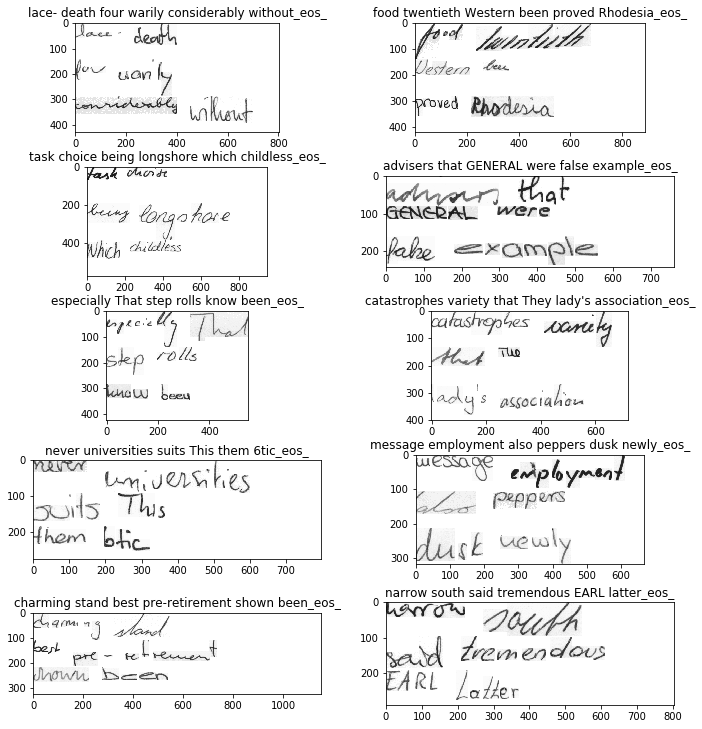

In [76]:
fig, axes = plt.subplots(5,2, figsize=(10, 10))
for i,ax in enumerate(axes.flat):
    row = new.iloc[i]
    im = Image.open(synth_path/row.filename)
    ax.imshow(im)
    ax.set_title(label_text(row.char_ids.split(' ')))
    
plt.tight_layout(pad=0.2)